# 01 – Preprocessing Pipeline Comparison

**Goal:** Compare different DICOM→NIfTI conversion methods and preprocessing options on P01 data.

| Option | What |
|--------|------|
| **A1** | SimpleITK direct DICOM read → NIfTI |
| **A2** | dcm2niix subprocess → NIfTI |
| **A3** | A1 + N4 bias correction + z-score normalisation |
| **A4** | A1 + 1mm isotropic resampling |

**Outputs:** timing table, file-size table, visual slice comparison.

In [1]:
import sys, os
from pathlib import Path
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd

NOTEBOOK_DIR = Path(os.getcwd())
REPO_ROOT    = NOTEBOOK_DIR.parent.parent.parent / "data"
DATA_ROOT    = REPO_ROOT / 'P01'
DICOM_DIR    = DATA_ROOT / 'DICOM'
BRATS_DIR    = DATA_ROOT / 'BraTS'
MASK_DIR     = DATA_ROOT / 'tumor segmentation'
OUT_DIR      = NOTEBOOK_DIR.parent / 'outputs' / '01_preprocessing'
OUT_DIR.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(NOTEBOOK_DIR.parent / 'utils'))
from dicom_utils import (
    dicom_to_nifti_sitk, dicom_to_nifti_dcm2niix,
    apply_n4_bias_correction, normalise_intensity_zscore,
    normalise_intensity_percentile, resample_to_isotropic,
    load_nifti, save_nifti, get_nifti_info, get_p01_dicom_series,
    get_p01_brats_paths, get_p01_mask_paths
)
from visualisation import plot_preprocessing_comparison, plot_preprocessing_table

# Use T1C baseline as test series
dicom_series = get_p01_dicom_series(DICOM_DIR)
test_series  = 'T1C_2020-01-07'
test_dir     = DICOM_DIR / test_series
print(f'Test DICOM series: {test_series}')
print(f'Files: {len(list(test_dir.glob("*.dcm")))}')

Test DICOM series: T1C_2020-01-07
Files: 36


In [2]:
# ── Option A1: SimpleITK ────────────────────────────────────────────────────
print('Running A1: SimpleITK conversion...')
a1_result = dicom_to_nifti_sitk(
    dicom_dir=test_dir,
    out_path=OUT_DIR / 'a1_sitk.nii.gz',
)
print(a1_result)

Running A1: SimpleITK conversion...
{'method': 'SimpleITK', 'out_path': '/Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/01_preprocessing/a1_sitk.nii.gz', 'size': (512, 512, 36), 'spacing_mm': (0.44921875, 0.44921875, 4.400000171994354), 'duration_s': 0.241, 'file_size_mb': 7.28}


In [3]:
# ── Option A2: dcm2niix ─────────────────────────────────────────────────────
print('Running A2: dcm2niix conversion...')
a2_result = dicom_to_nifti_dcm2niix(
    dicom_dir=test_dir,
    out_dir=OUT_DIR / 'a2_dcm2niix',
    filename='t1c_baseline',
)
if not a2_result.get('available'):
    print(f'⚠️  {a2_result["error"]}')
    print('   Skipping A2. Using A1 output as stand-in.')
    a2_result = {**a1_result, 'method': 'dcm2niix (not installed – using A1 as proxy)'}
else:
    print(a2_result)

Running A2: dcm2niix conversion...
⚠️  dcm2niix not found. Install with: brew install dcm2niix
   Skipping A2. Using A1 output as stand-in.


In [4]:
# ── Option A3: SimpleITK + N4 bias correction + z-score normalisation ───────
import time
print('Running A3: SimpleITK + N4 + z-score...')
t0 = time.perf_counter()

reader = sitk.ImageSeriesReader()
reader.SetFileNames(reader.GetGDCMSeriesFileNames(str(test_dir)))
raw_image = reader.Execute()

# N4 bias correction
n4_image = apply_n4_bias_correction(raw_image, n_iterations=50)

# Z-score normalisation
arr_n4 = sitk.GetArrayFromImage(n4_image).astype('float32')
arr_n4_norm = normalise_intensity_zscore(arr_n4)
norm_img = sitk.GetImageFromArray(arr_n4_norm)
norm_img.CopyInformation(n4_image)

a3_out = OUT_DIR / 'a3_n4_zscore.nii.gz'
sitk.WriteImage(norm_img, str(a3_out))
a3_duration = time.perf_counter() - t0
a3_result = {
    'method': 'SimpleITK + N4 + Z-score',
    'out_path': str(a3_out),
    'duration_s': round(a3_duration, 3),
    'file_size_mb': round(a3_out.stat().st_size / 1e6, 2),
}
print(a3_result)

Running A3: SimpleITK + N4 + z-score...
{'method': 'SimpleITK + N4 + Z-score', 'out_path': '/Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/01_preprocessing/a3_n4_zscore.nii.gz', 'duration_s': 4.01, 'file_size_mb': 19.89}


In [5]:
# ── Option A4: SimpleITK + 1mm isotropic resampling ──────────────────────────
print('Running A4: SimpleITK + 1mm isotropic resampling...')
t0 = time.perf_counter()

reader2 = sitk.ImageSeriesReader()
reader2.SetFileNames(reader2.GetGDCMSeriesFileNames(str(test_dir)))
raw2 = reader2.Execute()
resampled = resample_to_isotropic(raw2, target_spacing=1.0)
a4_out = OUT_DIR / 'a4_isotropic.nii.gz'
sitk.WriteImage(resampled, str(a4_out))
a4_duration = time.perf_counter() - t0

a4_result = {
    'method': 'SimpleITK + 1mm resample',
    'out_path': str(a4_out),
    'size': resampled.GetSize(),
    'spacing_mm': resampled.GetSpacing(),
    'duration_s': round(a4_duration, 3),
    'file_size_mb': round(a4_out.stat().st_size / 1e6, 2),
}
print(f'  Original spacing: {raw2.GetSpacing()}')
print(f'  Resampled spacing: {resampled.GetSpacing()}')
print(a4_result)

Running A4: SimpleITK + 1mm isotropic resampling...
  Original spacing: (0.44921875, 0.44921875, 4.400000171994354)
  Resampled spacing: (1.0, 1.0, 1.0)
{'method': 'SimpleITK + 1mm resample', 'out_path': '/Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/01_preprocessing/a4_isotropic.nii.gz', 'size': (230, 230, 158), 'spacing_mm': (1.0, 1.0, 1.0), 'duration_s': 0.231, 'file_size_mb': 6.73}


In [6]:
# ── Summary Table ────────────────────────────────────────────────────────────
results = [a1_result, a2_result, a3_result, a4_result]
df = pd.DataFrame([{
    'Method': r.get('method', 'Unknown'),
    'Duration (s)': r.get('duration_s', 'N/A'),
    'File Size (MB)': r.get('file_size_mb', 'N/A'),
    'Notes': r.get('error', ''),
} for r in results])

print('\n=== Preprocessing Comparison Summary ===')
print(df.to_string(index=False))
df.to_csv(OUT_DIR / 'preprocessing_summary.csv', index=False)
print('\nSaved: outputs/01_preprocessing/preprocessing_summary.csv')


=== Preprocessing Comparison Summary ===
                                      Method  Duration (s)  File Size (MB) Notes
                                   SimpleITK         0.241            7.28      
dcm2niix (not installed – using A1 as proxy)         0.241            7.28      
                    SimpleITK + N4 + Z-score         4.010           19.89      
                    SimpleITK + 1mm resample         0.231            6.73      

Saved: outputs/01_preprocessing/preprocessing_summary.csv


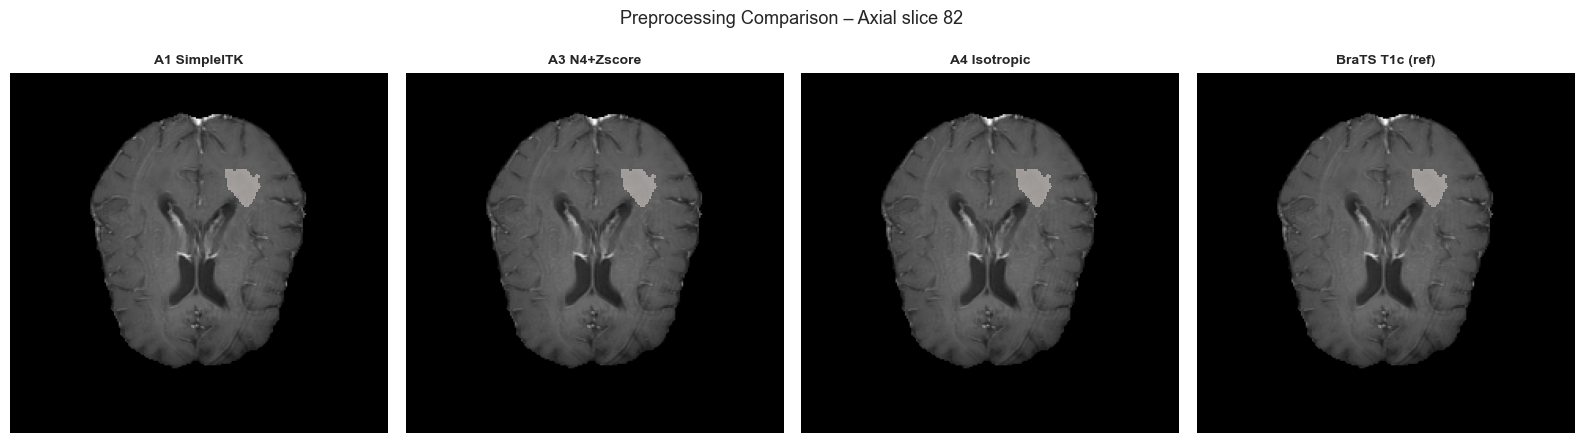

Saved: outputs/01_preprocessing/preprocessing_visual_comparison.png


In [7]:
# ── Visual comparison: axial slice for each option ────────────────────────────
# Load the GT mask for overlay reference
brats_paths = get_p01_brats_paths(BRATS_DIR)
mask_paths  = get_p01_mask_paths(MASK_DIR)
gt_arr, gt_aff, _ = load_nifti(mask_paths['baseline'])
best_sl = int(gt_arr.sum(axis=(0, 1)).argmax())

volumes = {}
for name, path in [
    ('A1 SimpleITK',    OUT_DIR / 'a1_sitk.nii.gz'),
    ('A3 N4+Zscore',    OUT_DIR / 'a3_n4_zscore.nii.gz'),
    ('A4 Isotropic',    OUT_DIR / 'a4_isotropic.nii.gz'),
]:
    if path.exists():
        arr, _, _ = load_nifti(path)
        # Ensure same Z-dimension for overlay (resample may change it)
        if arr.shape != gt_arr.shape:
            # Use BraTS NIfTI as reliable reference instead
            arr, _, _ = load_nifti(brats_paths['baseline'].get('t1c', next(iter(brats_paths['baseline'].values()))))
        volumes[name] = arr

# Also add the BraTS pre-processed t1c for comparison
brats_t1c, _, _ = load_nifti(brats_paths['baseline']['t1c'])
volumes['BraTS T1c (ref)'] = brats_t1c

fig = plot_preprocessing_comparison(volumes, mask=gt_arr, slice_idx=best_sl)
plt.savefig(OUT_DIR / 'preprocessing_visual_comparison.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: outputs/01_preprocessing/preprocessing_visual_comparison.png')

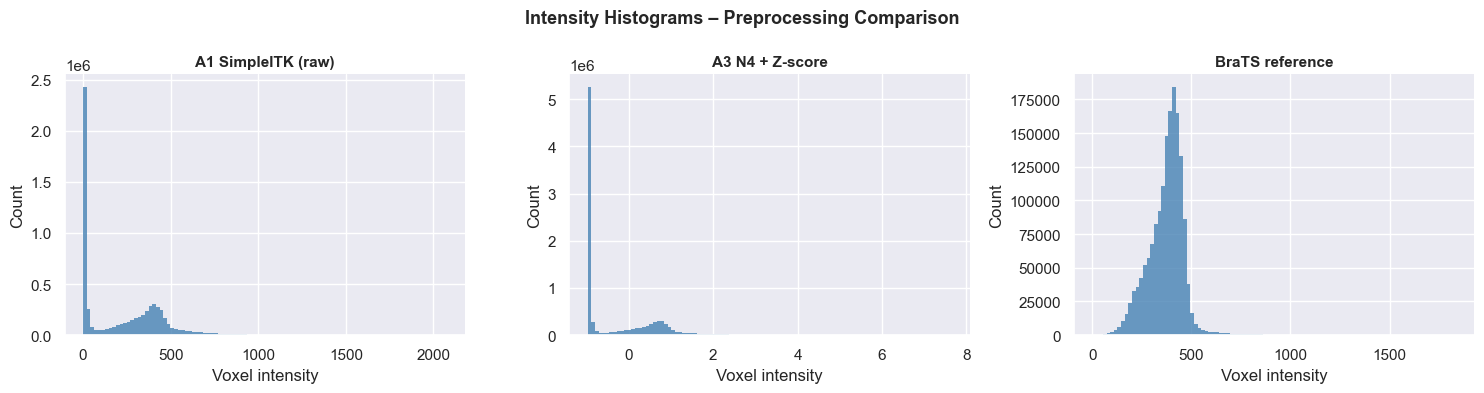

Saved: outputs/01_preprocessing/intensity_histograms.png


In [8]:
# ── Intensity histogram comparison ───────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, path) in zip(axes, [
    ('A1 SimpleITK (raw)',     OUT_DIR / 'a1_sitk.nii.gz'),
    ('A3 N4 + Z-score',        OUT_DIR / 'a3_n4_zscore.nii.gz'),
    ('BraTS reference',        brats_paths['baseline']['t1c']),
]):
    if Path(path).exists():
        arr, _, _ = load_nifti(path)
        nonzero   = arr[arr != 0].ravel()
        ax.hist(nonzero, bins=100, color='steelblue', edgecolor='none', alpha=0.8)
        ax.set_title(name, fontsize=11, fontweight='bold')
        ax.set_xlabel('Voxel intensity')
        ax.set_ylabel('Count')
        ax.spines[['top', 'right']].set_visible(False)

fig.suptitle('Intensity Histograms – Preprocessing Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUT_DIR / 'intensity_histograms.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: outputs/01_preprocessing/intensity_histograms.png')

## 📋 Conclusions

Fill in after running:
- Which method was fastest?
- Which produced the smallest files?
- Visual quality notes?
- **Recommendation for production pipeline:** ___